# Time Series & Diagnostic Analytics with Scikit-learn

This notebook covers the basics of working with time series data, feature engineering, grouping and aggregation, cross-tabulations, and a simple machine learning model using Scikit-learn.

We'll use a climate dataset from Delhi, India, which contains daily measurements of temperature, humidity, wind speed, and atmospheric pressure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
## Load the Dataset
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Time Series Basics

Convert the date column to datetime format and extract features like year, month, and day. This helps with time-based analysis.

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day,weekday
date,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2,2
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3,3
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4,4
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5,5


## Visualizing Time Series Data

Let's see how the temperature has changed over time.

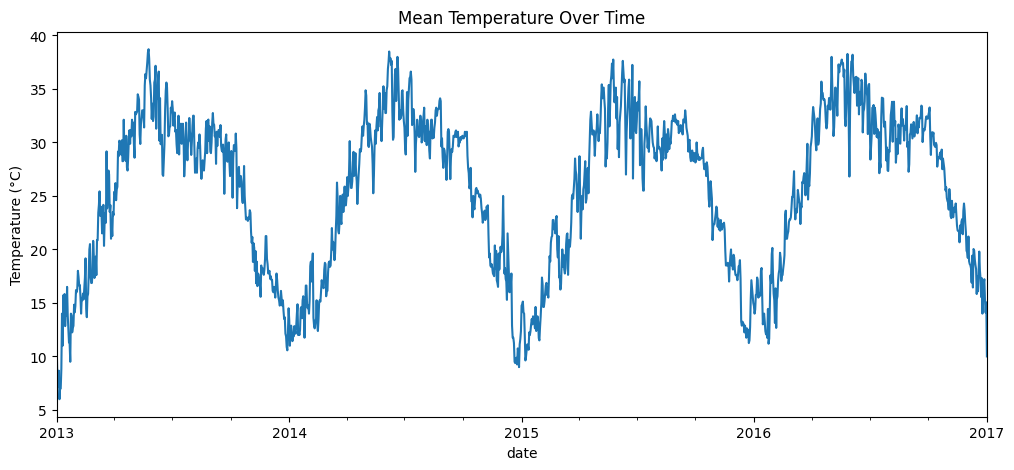

In [4]:
df['meantemp'].plot(title='Mean Temperature Over Time', figsize=(12,5))
plt.ylabel('Temperature (°C)')
plt.show()

## Advanced Feature Engineering

Create lag features and rolling averages to help models learn from trends in the data.


#### Understanding shift() – Creating Lag Features

When working with time series data, it's helpful to use information from previous time steps to predict future values. The ```.shift()``` function helps us do exactly that by "shifting" the values in a column up or down.
For example, ```df['meantemp'].shift(1)``` will take the temperature from the previous day and align it with the current day’s row. This gives us a new column ```(temp_lag_1)``` where each row shows what the temperature was one day earlier. These kinds of features are called lag features, and they are very useful in forecasting because they allow our machine learning model to "see" what happened in the past and use it to predict the future.
Think of it like this: if today is June 25, then ```shift(1)``` will bring in the value from June 24 to help predict June 25.

---

#### Understanding rolling() – Creating Moving Averages
The ```.rolling()``` function is used to create moving averages or rolling statistics over a specific window of time. For example, ```df['meantemp'].rolling(7).mean()``` calculates the average temperature over the last 7 days for each day.
This helps us smooth out short-term fluctuations and focus on long-term trends. It’s like asking, “What’s the average temperature of the past week?” for every single day.
Why is this useful? Because real-world data is noisy—temperatures can jump up and down day-to-day. A rolling average gives the model a more stable version of the trend, making it easier to learn patterns.
In this notebook, we create a new column called ```temp_roll_7``` which stores the 7-day moving average of temperature

In [5]:
df['temp_roll_7'] = df['meantemp'].rolling(7).mean()
df['temp_lag_1'] = df['meantemp'].shift(1)
df[['meantemp', 'temp_roll_7', 'temp_lag_1']].tail(10)

,meantemp,temp_roll_7,temp_lag_1
date,,,
2016-12-23,15.550000,17.446599,17.285714
2016-12-24,17.318182,17.420625,15.550000
2016-12-25,14.000000,17.123006,17.318182
2016-12-26,17.142857,17.020965,14.000000
2016-12-27,16.850000,16.599536,17.142857
2016-12-28,17.217391,16.480592,16.850000
2016-12-29,15.238095,16.188075,17.217391
2016-12-30,14.095238,15.980252,15.238095
2016-12-31,15.052632,15.656602,14.095238


##  Grouping Data for Insights

Group the data by month to see trends in temperature and humidity.

####  Understanding groupby() – Organizing Data into Meaningful Groups

The ```.groupby()``` function in pandas is used to split your data into groups based on the values in one or more columns. It’s very helpful when you want to analyze patterns across different categories.
For example, if we group our data by month, we can calculate the average temperature for each month and see how it changes throughout the year. The basic idea is:
"Group my data by X and then summarize it with Y."
In this notebook, we use:
```df.groupby('month').agg({'meantemp': 'mean'})```
This groups the data by month and calculates the average temperature for each group.

In [6]:
monthly_summary = df.groupby('month').agg({
    'meantemp': ['mean', 'std'],
    'humidity': 'mean'
})
monthly_summary

meantemp             humidity
            mean       std       mean
month                                
1      13.311914  2.465232  78.603500
2      17.620422  2.916742  67.959397
3      22.914103  3.255996  60.698463
4      29.376614  3.006285  39.036537
5      33.315889  2.789445  35.739941
6      33.734011  2.702637  50.628724
7      30.995782  2.192400  70.631436
8      30.601777  1.779262  70.469849
9      30.433216  1.514612  60.724564
10     27.113154  2.642065  61.220659
11     20.656855  2.431649  60.613909
12     15.666317  3.134796  72.392316

## Cross-Tabulation

Compare average temperatures across weekdays and months using cross-tabulation.

#### Understanding pd.crosstab() – Comparing Two Categorical Variables

```pd.crosstab()``` is used to create a summary table (like a spreadsheet) that shows the relationship between two categorical variables. Think of it as a more flexible pivot table.
In our case, we use ```pd.crosstab()``` to compare weekday ```(0 = Monday, 6 = Sunday)``` with month, showing the average temperature for each combination.
```pd.crosstab(df['weekday'], df['month'], values=df['meantemp'], aggfunc='mean')```
This creates a table where:
Rows are days of the week
Columns are months
Each cell contains the average temperature for that specific weekday-month combination
This kind of table helps uncover patterns like: “Is it usually hotter on Mondays in April than in August?”

In [7]:
ct = pd.crosstab(df['weekday'], df['month'], values=df['meantemp'], aggfunc='mean')
ct

month,1,2,3,4,5,6,7,8,9,10,11,12
weekday,,,,,,,,,,,,
0,13.193973,17.654071,22.307407,29.291282,33.102696,33.342857,30.748950,31.007973,30.523334,27.613151,20.854907,15.752525
1,13.296394,17.529773,22.802149,29.502844,32.793215,33.053291,31.222222,30.618783,31.080813,27.499669,20.658836,16.043566
2,13.511310,17.640737,22.870063,29.426488,33.025393,34.265476,31.368985,30.788097,30.502521,27.085013,20.581681,16.305971
3,13.364536,18.238575,23.487185,29.276767,33.617603,33.465075,31.531250,30.463711,30.126354,26.826772,20.567387,15.971296
4,13.492074,17.952324,23.347759,29.008964,33.729615,34.424814,30.832716,30.676102,30.208231,26.388730,20.595244,15.389496
5,13.240509,17.337277,23.102943,29.708088,33.245403,34.099265,30.626326,30.283158,30.287462,27.108840,20.700813,15.120085
6,13.057705,16.988095,22.554668,29.413690,33.617295,33.561111,30.560889,30.395939,30.251828,27.348120,20.632686,14.976261


## Predicting Temperature with Machine Learning

We'll create a simple model to predict the next day's temperature using recent temperature and humidity values.

In [ ]:
df_ml = df.dropna().copy()
features = ['meantemp', 'temp_roll_7', 'temp_lag_1', 'humidity']
X = df_ml[features]
y = df_ml['meantemp'].shift(-1).dropna()
X = X.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# 

## Evaluation

Check how well our model predicted the temperature and visualize the results.

Mean Squared Error: 2.57


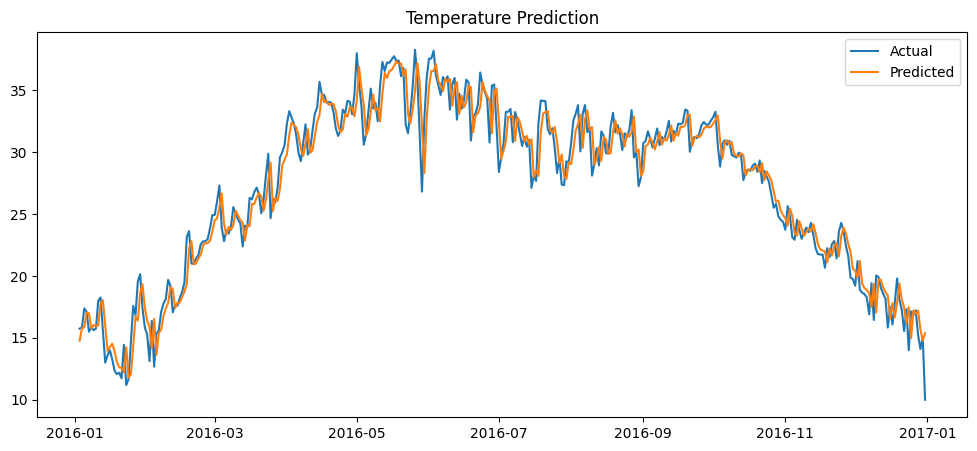

In [13]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Temperature Prediction')
plt.legend()
plt.show()